Advanced: compute_times & compute_phases
============================

Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.2 installed. (You can comment out this line if you don't use pip for your installation or don't want to update to the latest release).

In [ ]:
!pip install -I "phoebe>=2.2,<2.3"

As always, let's do imports and create a new Bundle.  See [Building a System](building_a_system.html) for more details.

In [1]:
import phoebe
from phoebe import u # units

b = phoebe.default_binary()

In [2]:
b.add_dataset('lc', times=phoebe.linspace(0,10,101), dataset='lc01')

<ParameterSet: 20 parameters | contexts: dataset, compute, constraint>

Overriding Computation Times
----------------------------

If `compute_times` is not empty (by either providing `compute_times` *or* `compute_phases`), the provided value will be used to compute the model instead of those in the `times` parameter.

In [3]:
print(b.filter(qualifier=['times', 'compute_times'], context='dataset'))

ParameterSet: 2 parameters
              times@lc01@dataset: [ 0.   0.1  0.2 ...  9.8  9.9 10. ] d
      compute_times@lc01@dataset: [] d


In [4]:
b.set_value('compute_times', phoebe.linspace(0,3,11))

In [5]:
b.run_compute()

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

In [6]:
print("dataset times: {}\ndataset compute_times: {}\nmodel times: {}".format(
    b.get_value('times', context='dataset'),
    b.get_value('compute_times', context='dataset'),
    b.get_value('times', context='model')
    ))

dataset times: [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10. ]
dataset compute_times: [0.  0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4 2.7 3. ]
model times: [0.  0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4 2.7 3. ]


Phase-Time Conversion
----------------------------------

In addition to the ability to provide `compute_times`, we can alternatively provide `compute_phases`.  These two parameters are linked via a constraint (see the [constraints tutorial](./constraints.ipynb)), with `compute_phases` *constrained* by default.

In [7]:
print(b.filter(qualifier=['times', 'compute_times', 'compute_phases'], context='dataset'))

ParameterSet: 3 parameters
              times@lc01@dataset: [ 0.   0.1  0.2 ...  9.8  9.9 10. ] d
      compute_times@lc01@dataset: [0.  0.3 0.6 ... 2.4 2.7 3. ] d
* compute_phases@binary@lc01@...: [0.  0.3 0.6 ... 0.4 0.7 0. ]


If we look at the constraint itself, we see that this translation is rudimentary and does not include all the same complexity as [b.to_phase](../api/phoebe.frontend.bundle.Bundle.to_phase.md) or [b.to_time](../api/phoebe.frontend.bundle.Bundle.to_time.md), but it will immediately react to a change in the orbital period (of the top-level orbit in the hierarchy).

In [8]:
print(b.get_constraint('compute_phases'))

Constrains (qualifier): compute_phases
Expression in solar units (value): ({compute_times@lc01@dataset} / {period@binary@component}) % 1.000000
Current Result (result): [0.  0.3 0.6 0.9 0.2 0.5 0.8 0.1 0.4 0.7 0. ]


In order to provide `compute_phases` instead of `compute_times`, we must call [b.flip_constraint](../api/phoebe.frontend.bundle.Bundle.flip_constraint.md).

In [9]:
b.flip_constraint('compute_phases', solve_for='compute_times')

<ConstraintParameter: {compute_times@lc01@dataset} = {compute_phases@binary@lc01@dataset} * {period@binary@component} (solar units) => [0.  0.3 0.6 0.9 0.2 0.5 0.8 0.1 0.4 0.7 0. ] d>

In [10]:
b.set_value('compute_phases', phoebe.linspace(0,1,11))

In [11]:
print(b.filter(qualifier=['times', 'compute_times', 'compute_phases'], context='dataset'))

ParameterSet: 3 parameters
              times@lc01@dataset: [ 0.   0.1  0.2 ...  9.8  9.9 10. ] d
*     compute_times@lc01@dataset: [0.  0.1 0.2 ... 0.8 0.9 1. ] d
  compute_phases@binary@lc01@...: [0.  0.1 0.2 ... 0.8 0.9 1. ]


Note that under the hood, PHOEBE **always** works in time-space, meaning it is the *constrained* value of `compute_times` that is being passed under-the-hood... even if those will result in slightly different phase-values due to the values of t0, dperdt, etc.

Also note that if directly passing `compute_phases` to [b.add_dataset](../api/phoebe.frontend.bundle.Bundle.add_dataset.md), the constraint will be flipped on our behalf.  We would then need to flip the constraint in order to provide `compute_times` instead.

Interpolating the Model
------------------------------

Whether or not we used `compute_times`/`compute_phases` or not, it is sometimes useful to be able to interpolate on the resulting model.  In the case where we provided `compute_times`/`compute_phases` to "down-sample" from a large dataset, this can be particularly useful.

We can call [interp_value](../api/phoebe.parameters.FloatArrayParameter.interp_value.md) on any [FloatArrayParameter](../api/phoebe.parameters.FloatArrayParameter.md).  

In [12]:
b.get_parameter('fluxes', context='model').get_value()

array([0.98319279, 2.00645217, 1.99253902, 1.99238306, 2.00632529,
       0.98319279, 2.00645217, 1.99253902, 1.99238306, 2.00632529,
       0.98319279])

In [13]:
b.get_parameter('fluxes', context='model').interp_value(times=1.0)

1.9970304694540848

In [15]:
b.get_parameter('fluxes', context='model').interp_value(times=phoebe.linspace(0,3,101))

array([0.98319279, 1.08551873, 1.18784467, 1.2901706 , 1.39249654,
       1.49482248, 1.59714842, 1.69947435, 1.80180029, 1.90412623,
       2.00645217, 2.00506085, 2.00366954, 2.00227822, 2.00088691,
       1.99949559, 1.99810428, 1.99671296, 1.99532165, 1.99393033,
       1.99253902, 1.99252342, 1.99250782, 1.99249223, 1.99247663,
       1.99246104, 1.99244544, 1.99242985, 1.99241425, 1.99239865,
       1.99238306, 1.99377728, 1.9951715 , 1.99656573, 1.99795995,
       1.99935418, 2.0007484 , 2.00214262, 2.00353685, 2.00493107,
       2.00632529, 1.90401204, 1.80169879, 1.69938554, 1.59707229,
       1.49475904, 1.39244579, 1.29013254, 1.18781929, 1.08550604,
       0.98319279, 1.08551873, 1.18784467, 1.2901706 , 1.39249654,
       1.49482248, 1.59714842, 1.69947435, 1.80180029, 1.90412623,
       2.00645217, 2.00506085, 2.00366954, 2.00227822, 2.00088691,
       1.99949559, 1.99810428, 1.99671296, 1.99532165, 1.99393033,
       1.99253902, 1.99252342, 1.99250782, 1.99249223, 1.99247

In the case of times, this will *automatically* interpolate in phase-space if the provided time is outside the range of the referenced times array.  If you have a logger enabled with at least the 'warning' level, this will raise a warning and state the phases at which the interpolation will be completed.

In [16]:
b.get_parameter('fluxes', context='model').interp_value(times=5)

0.9831927925898658

Determining & Plotting Residuals
----------------------------

One particularly useful case for interpolating is to compare a model (perhaps computed in phase-space) to a dataset with a large number of datapoints.  We can do this directly by calling [compute_residuals](../api/phoebe.parameters.ParameterSet.compute_residuals.md), which will handle any necessary interpolation and compare the dependent variable between the dataset and models.

Note that if there are more than one dataset or model attached to the bundle, it may be necessary to pass `dataset` and/or `model` (or filter in advanced and call compute_residuals on the filtered [ParameterSet](../api/phoebe.paraemters.ParameterSet.md).

To see this in action, we'll first create a "fake" observational dataset, add some noise, recompute the model using `compute_phases`, and then compute the residuals.

In [17]:
b.add_dataset('lc', 
              times=phoebe.linspace(0,10,1000),
              dataset='lc01',
              overwrite=True)

<ParameterSet: 20 parameters | contexts: dataset, compute, constraint>

In [18]:
b.run_compute(irrad_method='none')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

In [19]:
fluxes = b.get_value('fluxes', context='model')
b.set_value('fluxes', context='dataset', value=fluxes)

In [20]:
b.flip_constraint('compute_phases', solve_for='compute_times')

<ConstraintParameter: {compute_times@lc01@dataset} = {compute_phases@binary@lc01@dataset} * {period@binary@component} (solar units) => [] d>

In [21]:
b.set_value('compute_phases', phoebe.linspace(0,1,101))

In [22]:
b.set_value('teff', component='primary', value=5950)

In [23]:
b.run_compute(irrad_method='none')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

In [24]:
print(len(b.get_value('fluxes', context='dataset')), len(b.get_value('fluxes', context='model')))

(1000, 101)


In [25]:
b.compute_residuals()

<Quantity [-0.03681835, -0.03661619, -0.03670043, -0.03685692, -0.03698388,
           -0.03696743, -0.03695564, -0.03714817, -0.03717157, -0.0371856 ,
           -0.03725332, -0.03730022, -0.03732466, -0.03735579, -0.03738683,
           -0.03744787, -0.03747353, -0.03756298, -0.03760218, -0.03761259,
           -0.0376065 , -0.03763708, -0.0377037 , -0.03770604, -0.03773001,
           -0.03762411, -0.03774265, -0.03775119, -0.03771485, -0.03780185,
           -0.03773623, -0.03771217, -0.0375733 , -0.03763671, -0.03749983,
           -0.03750276, -0.03743963, -0.037451  , -0.03736805, -0.03731474,
           -0.0372846 , -0.0372944 , -0.03723528, -0.0369616 , -0.03508127,
           -0.03286511, -0.0280351 , -0.02147501, -0.01432567, -0.0078599 ,
           -0.17038423, -0.00744108, -0.01464007, -0.02187356, -0.02811824,
           -0.03256804, -0.03586239, -0.03727923, -0.03728409, -0.03727093,
           -0.03730617, -0.03739948, -0.03737528, -0.03736783, -0.03747144,
           -

If we plot the dataset and model, we see that the model was only computed for one cycle, whereas the dataset extends further in time.

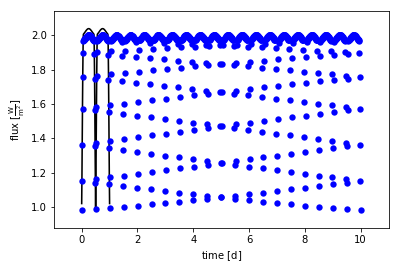

In [26]:
afig, mplfig = b.plot(show=True)

But we can also plot the residuals.  Here, [compute_residuals](../api/phoebe.parameters.ParameterSet.compute_residuals.md) is called internally, interpolating in phase-space, and then plotted in time-space.  See the options for `y` in the [plot API docs](../api/phoebe.parameters.ParameterSet.plot.md) for more details.

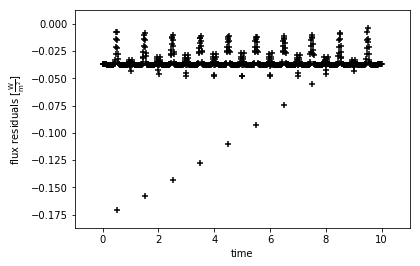

In [27]:
afig, mplfig = b.plot(y='residuals', show=True)